# Erste Modelle: Normalverteilung, Lognormalverteilung und Regression

## Was sind Modelle?

Modelle sind allgemein gesprochen vereinfachte Abbildungen der Wirklichkeit. Jeder kennt ein
Modell des Sonnensystems: Es besteht aus der Sonne, den Planeten und vielleicht noch den großen Monden.
Es zeigt aber nicht die Asteroiden und die kleinen Monde. Möchten wir ein Sonnensystem am PC
simulieren, berücksichtigen wir auch nur die großen Planeten und durch die Gesetze der Schwerkraft
können wir die Bewegung simulieren.

Bezogen auf Daten haben wir eine ähnliche Situation: Wir haben echte (also gemessene) Werte. Um
Aussagen darüber zu gewinnen, können wir natürlich alle Werte aus der Datenbank laden (das können
mehrere Millionen Datensätze sein) und sie analysieren. Oder wir sehen uns an, ob es mathematische
Beschreibungen (Modelle) dafür gibt, die wir mit einfachen Grundparametern definieren können.

## Laden der Daten der Wetterstationen

Damit wir wieder unsere Wetterdaten analysieren können, laden wir sie und erzeugen
lückenlose Tageswerte.

In [1]:
import pandas as pd
import parseSynop as ps    # Datei parseSynop.py laden
data_vienna = ps.readFile("synop_11034.txt.bz2")  # Wien Innere Stadt
data_gump = ps.readFile("synop_11082.txt.bz2")    # Gumpoldskirchen
data_rax = ps.readFile("synop_11180.txt.bz2")     # Rax Bergstation
data = pd.concat([data_gump, data_rax, data_vienna])

In [2]:
# Alle Tage vom ersten bis zum letzten Tag der Beobachtungen aus Wien
days = pd.Series(pd.date_range(start=data.date.min(), end=data.date.max(), name="date", freq='D'), name="date")
# Alle Stationen im Datenbestand (3 Stück)
stations = pd.Series(data.station.unique(), name="station")
# Um lückenlose Daten zu erhalten ordnen wir jeden Tag alle Stationen zu.
days_stations = pd.merge(days, stations, how="cross")
# Nun gruppieren wir die Rohdaten pro Station und Tag.
data_daily = data.groupby(["station", "date", "year", "month", "day"]) \
    .aggregate(Tavg=("temp", "mean"), Tmax=("max_temp", "max"), Tmin=("min_temp", "min")) \
    .reset_index()
# Der LEFT JOIN erzeugt für jeden Tag pro Station einen Datensatz.
data_daily = pd.merge(days_stations, data_daily, \
    left_on=["date", "station"], right_on=["date", "station"], how="left")
data_daily.head(5)

,date,station,year,month,day,Tavg,Tmax,Tmin
0,2000-01-01,11082,2000.0,1.0,1.0,-1.650000,1.2,-5.5
1,2000-01-01,11180,2000.0,1.0,1.0,-6.733333,NaN,NaN
2,2000-01-01,11034,2000.0,1.0,1.0,1.112500,2.6,-0.9
3,2000-01-02,11082,2000.0,1.0,2.0,-1.000000,3.0,-3.6
4,2000-01-02,11180,2000.0,1.0,2.0,-5.333333,NaN,-5.4


## Die Normalverteilung als Modell der Häufigkeitsverteilung

Vielleicht verwundert es einige, dass die Normalverteilung als Modell bezeichnet wird. Im vorigen
Kapitel *Deskriptive Statistik* haben wir aus den Daten die Häufigkeitsverteilung gewonnen und
berechnet, wie wahrscheinlich das Unterschreiten einer gewissen Temperatur z. B. im Jänner ist.

Sehen wir uns die Tiefstwerte der Lufttemperatur im Jänner in Wien (Station 11034) noch einmal an:

count    661.000000
mean       0.313767
std        4.299437
min      -14.800000
25%       -2.500000
50%        0.400000
75%        3.100000
max       13.000000
Name: Tmin, dtype: float64

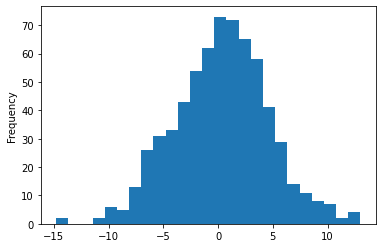

In [3]:
display(data_daily.loc[(data_daily.station == 11034) & (data_daily.month == 1), "Tmin"].describe())
data_daily.loc[(data_daily.station == 11034) & (data_daily.month == 1), "Tmin"].plot.hist(bins=25);

Wir erkennen optisch, dass die Verteilung der Daten eine Glockenkurve bildet. Um festzustellen,
an wie vielen Tagen es im Jänner in Wien unter 0° hatte, müssen wir nur zählen und das Ergebnis
durch die Anzahl der Werte dividieren:

In [4]:
((data_daily.station == 11034) & (data_daily.month == 1) & (data_daily.Tmin < 0)).sum() / \
((data_daily.station == 11034) & (data_daily.month == 1) & (data_daily.Tmin.notna())).sum()    

0.44780635400907715

Für diese Aussage brauchen wir allerdings den gesamten Datenbestand. Die Normalverteilung ist
eine mathematische Formel, die Glockenkurven beschreibt. Sie gibt uns an, wie wahrscheinlich das Auftreten eines Wertes ist.
Sie ist über 2 Parameter definiert: Mittelwert und Standardabweichung.

### Schritt 1: Erstellen des Modelles ("Train")

Auf Basis der tatsächlichen Werte können wir eine Normalverteilung gewinnen, die die Werte bestmöglich
anpasst. Im Paket *scipy* laden wir die Klasse *norm* aus dem Modul *scipy.stats*. Die Funktion
*norm* besitzt eine Methode *fit()*. Damit werden die Modellparameter aus den Rohdaten gewonnen.
Später werden wir diesen Vorgang als "Trainieren des Modelles" bezeichnen.

In [5]:
from scipy.stats import norm
tmin_jan = data_daily.loc[(data_daily.station == 11034) & (data_daily.month == 1) & (data_daily.Tmin.notna()), "Tmin"]
# Liefert ein Tupel mit den Modellparametern, welches in separate Variablen geschrieben wird.
mean, stdev = norm.fit(tmin_jan)
print(mean, stdev, tmin_jan.mean(), tmin_jan.std())

0.31376701966717085 4.296183564813475 0.31376701966717085 4.299437017430311


Wir sehen, dass wir auch ohne *fit()* die 2 Parameter ermitteln könnten. Es ist einfach der
Mittelwert und die Standardabweichung der Werte. Der kleine Unterschied zwischen den Standardabweichungen
entsteht durch die Berechnung. In fit() wird durch N dividiert, in std wird die empirische Standardabweichung,
wo durch N-1 dividiert wird, ermittelt. Der Unterschied ist aber so klein, dass er nicht ins Gewicht
fällt.

Nun erstellen wir eine Normalverteilung mit den ermittelten 2 Parametern. Es ist unser Modell.
Mit *cdf(x)* berechnen wir die sogenannte "Cumulative distribution function". Es gibt an, wie
wahrscheinlich das Auftreten eines Wertes kleiner als x ist, also *P(X<x)*.

In [6]:
model = norm(mean, stdev)
print(f"Wahrscheinlichkeit für Tmin < 0° im Jänner: {round(model.cdf(0), 3)}")
print(f"Wahrscheinlichkeit für Tmin < -15° im Jänner: {round(model.cdf(-15), 6)}")


Wahrscheinlichkeit für Tmin < 0° im Jänner: 0.471
Wahrscheinlichkeit für Tmin < -15° im Jänner: 0.000182


Wir sehen, dass für 0° der Wert lediglich 2.6% abweicht. Es genügen also genau 2 Werte (Mittelwert
und Standardabweichung), um zu berechnen, wie Wahrscheinlich das Auftreten von Frost im Jänner ist.

### Schritt 2: Evaluate

Wir haben mit einem Einzelwert (0°) von der Genauigkeit überzeugen können. Wir wollen aber für
den gesamten Wertebereich einen Eindruck verschaffen. Dafür Plotten wir einfach das Histogramm
und die Verteilungsfunktion in einem Diagramm. Dabei lassen wir für den gesamten Wertebereich
die Wahrscheinlichkeit für diesen Messwert ausrechnen. Dies erledigt die sogenannte *Dichtefunktion*
und ist mit *pdf()* abrufbar.

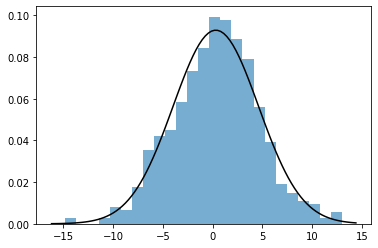

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(tmin_jan, bins=25, density=True, alpha=0.6)
xmin, xmax = plt.xlim()           # Was ist der kleinste und größte x Wert im Histogramm?
x = np.linspace(xmin, xmax, 100)  # 100 Werte zwischen min und max mit gleichem Abstand erzeugen.
plt.plot(x, model.pdf(x), 'k')    # Für jeden dieser Werte die Dichtefunktion der Normalverteilung ausgeben.
plt.show()

Nun sehen wir, dass eine sehr gute Anpassung des Modells vorliegt. Das ist jedoch nicht immer der
Fall. Wir betrachten nun die Tiefsttemperaturen des ganzen Jahres und plotten die Werte samt
der best angepassten Normalverteilung:

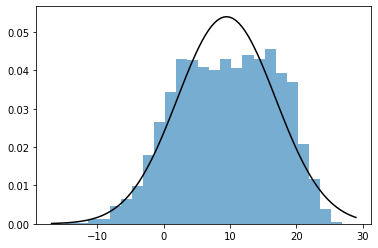

In [8]:
tmin = data_daily.loc[(data_daily.station == 11034) & (data_daily.Tmin.notna()), "Tmin"]
mean, stdev = norm.fit(tmin)
model = norm(mean, stdev)
plt.hist(tmin, bins=25, density=True, alpha=0.6)
xmin, xmax = plt.xlim()           # Was ist der kleinste und größte x Wert im Histogramm?
x = np.linspace(xmin, xmax, 100)  # 100 Werte zwischen min und max mit gleichem Abstand erzeugen.
plt.plot(x, model.pdf(x), 'k')    # Für jeden dieser Werte die Dichtefunktion der Normalverteilung ausgeben.
plt.show()

Unsere Normalverteilung ist im Vergleich zu den Werten zu spitz. Die Werte sind nicht normalverteilt.
Ursache: Im Laufe des Jahres wandert die Sonne vom Süden (21.12.) über den Äquator (21.3. und 23.9.)
nach Norden (21.6.). Der Äquator wird also 2x durchquert, dadurch ist die Temperaturverteilung im
Frühling und Herbst ähnlich. Sie hat also mehr Gewicht in den Werten als der Sommer oder Winter.

### Warum ist die Verteilung so bekannt und wichtig?

Ein Messwert hängt oft von sehr vielen Faktoren ab. Wenn du die gleiche Strecke täglich läufst,
brauchst du nicht immer exakt gleich lange. An manchen Tagen bist du motiviert, die Schuhe drücken
nicht und du schaffst die Strecke schneller. An anderen Tagen kommst du nicht so gut voran. Das hat
sehr viele Faktoren (Schuhe, Motivation, Boden, Wind, Temperatur, ...).

Wir simulieren nun diese Situation mit einem Würfelspiel. Wir würfeln 4 Würfel und bilden die Summe.
Der niedrigste Wert ist 4, der höchste Wert der rauskommen kann ist 24. Diese Würfel sind sozusagen
die Faktoren für deinen Lauf. Sie summieren sich zu einer Zeit.

Die Randbereiche (4 und 24) sind sehr selten. Es müssen alle Würfel den Wert 1 oder 6 haben. Mit
*np.random.randint(1, 7, 4)* können wir 4 Zufallszahlen zwischen 1 und 6 generieren, um den Wurf
zu simulieren. Damit die Werte bei jeder Ausführung gleich sind, verwenden wir einen fixen
Seed Wert. Dass die 5 mehrmals vorkommt liegt nicht an einem schlecht programmierten
Zufallszahlengenerator. Die Würfe wissen nichts vom Vorgänger, sie sind*unabhängige Zufallsexperimente*.

In [9]:
import numpy as np
np.random.seed(22)
np.random.randint(1, 7, 4)

array([6, 5, 5, 1])

Nun wollen wir 5 Würfe mit diesen 4 Würfeln simulieren. *range(0,5)* erzeugt eine Zahlenfolge
*0, 1, 2, 3, 4*. Sie ist sozusagen die Spielnummer. Mit *map()* können wir für jede dieser Nummer
die zahlen generieren. Das ist vergleichbar mit *apply()* und steht für jedes iterierbare Objekt
in Python zur Verfügung.

In [10]:
np.random.seed(22)
wuerfe = pd.DataFrame(map(lambda x: np.random.randint(1, 7, 4), range(0,5)))
wuerfe["SUM"] = wuerfe.apply(lambda row: row.sum(), axis=1)
wuerfe

,0,1,2,3,SUM
0,6,5,5,1,17
1,5,4,5,1,15
2,5,6,3,5,19
3,6,1,3,6,16
4,3,2,1,1,7


Die Summen kommen nur 1x vor. Bei 100 Spielen ergibt sich aber schon ein erstes Bild
der Häufigkeiten:

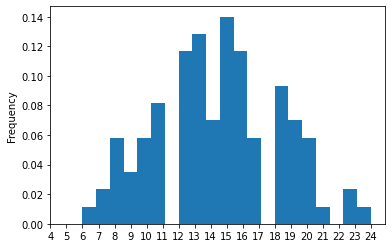

In [11]:
np.random.seed(22)
wuerfe = pd.DataFrame(map(lambda x: np.random.randint(1, 7, 4), range(0,100)))
wuerfe["SUM"] = wuerfe.apply(lambda row: row.sum(), axis=1)
wuerfe["SUM"].plot.hist(bins=21, density=True).set_xticks(range(4,25));


Der mittlere Bereich (Summe um 14 herum) kommt in unseren 100 Spieldurchgängen schon erkennbar
häufiger vor als die Randbereiche. Die Summen haben aber noch Lücken, da wir zu wenige Durchläufe
analysiert haben. Dadurch sind einige Werte noch nicht aufgetreten. Nun wollen wir 10 000 Durchgänge
analysieren:

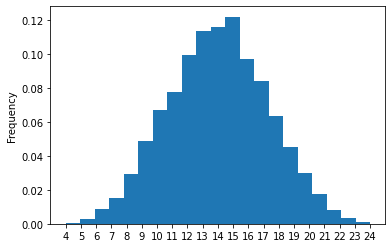

In [12]:
np.random.seed(22)
wuerfe = pd.DataFrame(map(lambda x: np.random.randint(1, 7, 4), range(0,10000)))
wuerfe["SUM"] = wuerfe.apply(lambda row: row.sum(), axis=1)
wuerfe["SUM"].plot.hist(bins=21, density=True).set_xticks(range(4,25));

Die Kurve sieht jetzt aus wie eine *Gaußsche Glockenkurve*. Sie entsteht immer dann, wenn sich
mehrere Faktoren zu einem Wert aufsummieren. Das ist in der Natur sehr oft der Fall, und deswegen
ist sie die wichtigste Verteilung. Der genaue Beweis dafür ist im
[Zentralen Grenzwertsatz](https://de.wikipedia.org/wiki/Zentraler_Grenzwertsatz) der Wahrscheinlichkeitsrechnung
zu finden.

## Lognormalverteilung

In einer Übung zur deskriptiven Statistik haben wir analysiert, wie viele Stunden nach dem
Aussenden der Mail die Lehrenden auf die Umfrage geklickt haben. Dafür laden wir die
Daten und berechnen die Differenz zwischen Umfragestart (START) und dem Sendedatum der Mail:

In [13]:
sga_data = filelist = pd.read_excel("sga_umfrage.xlsx", usecols=["PERSON", "START"])
mail_sent = pd.to_datetime("2022-05-03T13:24:00")
delay = (sga_data.START - mail_sent)/pd.Timedelta(1, "h")
delay.head(3)

0    0.074167
1    0.024444
2    0.076944
Name: START, dtype: float64

Nun zeigen wir an, wie die Werte von *DELAY* verteilt sind:

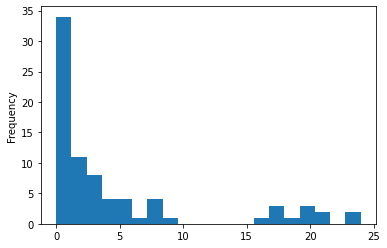

In [14]:
delay[delay<24].plot.hist(bins=20);

Es ergibt sich ein ganz anderes Bild: eine große Säule liegt bei 0, danach fallen die Werte
schnell ab. Am rechten Ende ist die Verteilung ausgezogen, da nach 15 oder 20 Stunden immer noch
vereinzelt Personen teilnahmen. Deswegen zeigen wir auch nur die ersten 24 Stunden an, danach würden
auch noch einzelne Werte vorkommen und das Histogramm wäre zu breit. Die Lücke nach 10 Stunden ist
auch erklärbar: in der Nacht gibt es keine Teilnehmer.

Da wir nur knapp über 100 Datensätze haben, zeigt das Histogramm Lücken. Es gibt sicher einige,
die eine Umfrage auch um 4 Uhr beantworten würden. In dieser Menge waren sie allerdings nicht
enthalten. 

Verteilungen von nichtnegativen Werten, etwa Lebensdauern, Wartezeiten oder Einkommen
sind häufig linkssteil (vgl. Fahrmeir: Statistik, 7. Aufll, S301). Es gibt nämlich eine
harte untere Grenze. In unserem Fall ist sie 0, denn vor der Mail kann keiner die Umfrage
beantworten. Auch für das Körpergewicht gibt es biologische Untergrenzen. Ab einem gewissen Wert
steigt die Verteilung dann stark an um dann am anderen Ende langsam auszulaufen.

Denke an deinen Weg in die Schule und die Zeit, die du dafür brauchst. Nach einigen Wochen kannst
du diese Zeit sehr gut abschätzen. Es gibt aber Tage, an denen du schneller bist, wenn z. B. der
Bus gleich gekommen ist. An anderen Tagen brauchst du länger, da der Bus im Stau gestanden ist.
Selten kommst du 1 Stunde zu spät, da die Schnellbahn ganz ausgefallen ist.

Hier erkennen wir auch, dass es eine *untere Grenze* gibt. Wenn alle Verkehrsmittel gleich kommen
und auch sonst alles passt, erreichst du die Mindestzeit. Kürzer geht es nicht mehr. Andererseits
ist nach oben hin (fast) keine Grenze gesetzt.

Die **Lognormalverteilung** oder **Logarithmische Normalverteilung** beschreibt diese Verteilung. Wir
können Sie mit scipy auch erstellen. Es sind 3 Werte nötig, um sie zu beschreiben: *shape*, *location* und
*scale*. Ersteres ist die Form (wie "langgezogen" die Verteilung ist), zweiteres bestimmt den Nullpunkt
und der dritte Parameter ist ein Skalierungsfaktor.

> lognorm.pdf(x, s, loc, scale) is identically equivalent to lognorm.pdf(y, s) / scale with y = (x - loc) / scale.
> (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html)


### Erzeugen der am Besten angepassten Lognormalverteilung

Mit *fit()* wird die Lognormalverteilung aus den Werten von delay erstellt. Mit *cdf()* können wir
ablesen, wie viel % der Werte ein Delay kleiner dieses Wertes haben.

In [15]:
from scipy.stats import lognorm
shape, location, scale = lognorm.fit(delay)
model = lognorm(shape, location, scale)
print (f"Anteil der Werte mit kleiner 1h delay aus der Lognormalverteilung: {round(model.cdf(1), 3)}")
print (f"Anteil der Werte mit kleiner 1h delay aus den Daten: {round((delay<1).sum()/delay.count(), 3)}")
print (f"Anteil der Werte mit kleiner 10min delay aus der Lognormalverteilung: {round(model.cdf(1/6), 3)}")
print (f"Anteil der Werte mit kleiner 10min delay aus den Daten: {round((delay<1/6).sum()/delay.count(), 3)}")


Anteil der Werte mit kleiner 1h delay aus der Lognormalverteilung: 0.27
Anteil der Werte mit kleiner 1h delay aus den Daten: 0.299
Anteil der Werte mit kleiner 10min delay aus der Lognormalverteilung: 0.079
Anteil der Werte mit kleiner 10min delay aus den Daten: 0.075


Das Modell beschreibt also sehr gut die echte Verteilung. 27% unserer Teilnehmer haben die Umfrage
also in der ersten Stunde beantwortet. Wollen wir nun wissen, wann 50% erreicht wurden, können wir
das mit *ppf()* leicht herausfinden. *ppf()* bekommt eine *Wahrscheinlichkeit p* als Parameter und gibt
uns den Wert x an, für den *P(X<x)=p* gilt.

In [16]:
print (f"50 % der Teilnehmer haben innerhalb dieses Zeitraumes geantwortet: {round(model.ppf(.5), 1)}h")
print (f"75 % der Teilnehmer haben innerhalb dieses Zeitraumes geantwortet: {round(model.ppf(.75), 1)}h")
print (f"90 % der Teilnehmer haben innerhalb dieses Zeitraumes geantwortet: {round(model.ppf(.9), 1)}h")
print (f"95 % der Teilnehmer haben innerhalb dieses Zeitraumes geantwortet: {round(model.ppf(.95), 1)}h")
print (f"99 % der Teilnehmer haben innerhalb dieses Zeitraumes geantwortet: {round(model.ppf(.99), 1)}h")
print (f"100 % der Teilnehmer haben innerhalb dieses Zeitraumes geantwortet: {round(model.ppf(1), 1)}")

50 % der Teilnehmer haben innerhalb dieses Zeitraumes geantwortet: 4.0h
75 % der Teilnehmer haben innerhalb dieses Zeitraumes geantwortet: 18.6h
90 % der Teilnehmer haben innerhalb dieses Zeitraumes geantwortet: 74.0h
95 % der Teilnehmer haben innerhalb dieses Zeitraumes geantwortet: 169.0h
99 % der Teilnehmer haben innerhalb dieses Zeitraumes geantwortet: 796.2h
100 % der Teilnehmer haben innerhalb dieses Zeitraumes geantwortet: inf


Nach der Verteilung haben also niemals alle geantwortet. Die Wahrscheinlichkeit ist zwar sehr gering,
aber es kann zum Zeitpunkt x nie ausgeschlossen werden, dass noch eine Antwort zum Zeitpunkt x+1
kommt. Grafisch können wir wieder Modell und Wirklichkeit im Plot gegenüberstellen:

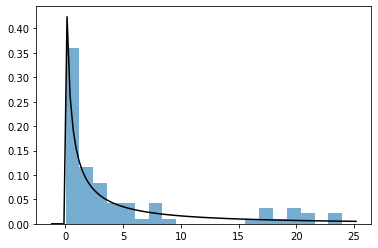

In [17]:
plt.hist(delay[delay < 24], bins=20, density=True, alpha=0.6)
xmin, xmax = plt.xlim()           # Was ist der kleinste und größte x Wert im Histogramm?
x = np.linspace(xmin, xmax, 100)  # 100 Werte zwischen min und max mit gleichem Abstand erzeugen.
plt.plot(x, model.pdf(x), 'k')    # Für jeden dieser Werte die Dichtefunktion der Normalverteilung ausgeben.
plt.show()

## Korrelation (Wiederholung)

Im letzten Beispiel haben wir die Tmax Werte der einzelnen Stationen gegenübergestellt und festgestellt,
dass sie durch die Nähe sehr ähnlich sind.

station,date,year,month,day,11034,11082,11180
0,2000-01-01,2000.0,1.0,1.0,2.6,1.2,NaN
1,2000-01-02,2000.0,1.0,2.0,2.1,3.0,NaN
2,2000-01-03,2000.0,1.0,3.0,4.2,-0.5,NaN


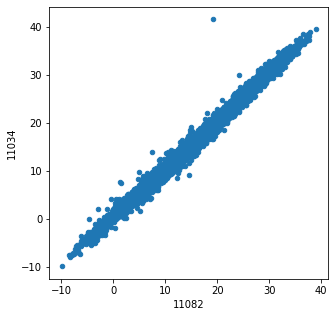

In [18]:
tmax_per_station = data_daily.pivot(index=["date", "year", "month", "day"], columns="station", values="Tmax") \
    .reset_index()
display(tmax_per_station.head(3))
tmax_per_station.plot.scatter(x=11082, y=11034, figsize=(5, 5));

Mit *corrcoef()* haben wir auch den Korrelationskoeffizieten bestimmt:

In [19]:
import numpy as np

valid_data = tmax_per_station[11034].notna() & tmax_per_station[11082].notna() & tmax_per_station[11180].notna()
np.corrcoef(tmax_per_station.loc[valid_data, [11082, 11034, 11180]], rowvar=False)

array([[1.        , 0.99604204, 0.8983869 ],
       [0.99604204, 1.        , 0.90187362],
       [0.8983869 , 0.90187362, 1.        ]])

## Berechnen von Tmax anhand anderer Stationen

Im vorigen Beispiel haben wir festgestellt, dass z. B. die Station Wien Innere Stadt an einigen Tagen
keinen Wert von Tmax übermittelt hat. Können wir die fehlenden Werte aus anderen Werten errechnen?
Die große Ähnlichkeit zu den Tmax Werten der Station Gumpoldskirchen (11082) kann hier hilfreich
sein. Im Mathematikunterricht wurde die *Regressionsgleichung* als einfaches Modell demonstriert,
wie sich ein Wert aus einem anderen Wert berechnen lässt.

Im Paket *numpy* steht die Funktion *polyfit()* zur Verfügung. Sie ermittelt mit einer Anweisung
diese Gleichung, die im Mathematikunterricht oft mühsam mit Tabellen händisch ermittelt wurde. Sie
liefert die Parameter a und b der Regressionsgleichung Y = a + b*X. Damit wir diese Gleichung in
Python als Funktion nutzen können, erzeugt *poly1d* aus diesen Parametern eine Funktion, die wir
normal aufrufen können.

Damit können wir eine Spalte *11034_predicted* ergänzen.

In [20]:
# Generiert Tmax_von_11034 = a + b * Tmax_von_11082
valid_data = tmax_per_station[11034].notna() & tmax_per_station[11082].notna()
fit = np.polyfit(x=tmax_per_station.loc[valid_data, 11082], y=tmax_per_station.loc[valid_data, 11034], deg=1)
display(fit)
reg_function = np.poly1d(fit)

tmax_per_station["11034_predicted"] = tmax_per_station.apply(lambda row: reg_function(row[11082]), axis=1)
tmax_per_station[(tmax_per_station.year == 2000) & (tmax_per_station.month == 7) & (tmax_per_station.day > 25)]

array([1.00522123, 0.35084073])

station,date,year,month,day,11034,11082,11180,11034_predicted
284,2000-07-26,2000.0,7.0,26.0,27.0,25.8,17.0,26.285548
285,2000-07-27,2000.0,7.0,27.0,NaN,26.7,15.2,27.190248
286,2000-07-28,2000.0,7.0,28.0,NaN,20.8,11.6,21.259442
287,2000-07-29,2000.0,7.0,29.0,22.6,20.9,10.6,21.359964
288,2000-07-30,2000.0,7.0,30.0,22.5,22.2,10.5,22.666752
289,2000-07-31,2000.0,7.0,31.0,NaN,22.6,12.4,23.068841


### Fehlerbestimmung

Da die Korrelation zwar hoch (0.996), aber nicht 1 ist, ergibt sich zwangsläufig eine Abweichung
zwischen dem berechneten und den tatsächlichen Wert. Suchen wir einmal alle Daten, an denen
die Station 11082 den Wert Höchstwert von 28.2° übermittelt hat. Würde eine Funktion den Zusammenhang
zwischen den beiden Stationen exakt beschreiben, müssen die Werte von Wien auch alle ident sein
(funktionaler Zusammenhang).

In [21]:
tmax_per_station[tmax_per_station[11082] == 28.2].head(5)

station,date,year,month,day,11034,11082,11180,11034_predicted
1072,2002-08-31,2002.0,8.0,31.0,29.2,28.2,17.7,28.698079
1370,2003-06-14,2003.0,6.0,14.0,29.4,28.2,17.0,28.698079
1790,2004-08-02,2004.0,8.0,2.0,28.2,28.2,17.2,28.698079
3979,2010-07-23,2010.0,7.0,23.0,29.0,28.2,18.6,28.698079
4000,2010-08-13,2010.0,8.0,13.0,29.7,28.2,15.3,28.698079


Wir erkennen, dass beim selben X Wert (28.2°) verschiedene Y Werte vorliegen. Der vorhergesagte
Wert ist natürlich immer gleich, da wir eine Funktion mit dem Parameter Tmax von 11082 verwenden.
Ergänzen wir nun eine Spalte mit dem Fehler des berechneten Wertes.

In [22]:
tmax_per_station["11034_predicted_err"] = tmax_per_station[11034] - tmax_per_station["11034_predicted"]
tmax_per_station.head(5)

station,date,year,month,day,11034,11082,11180,11034_predicted,11034_predicted_err
0,2000-01-01,2000.0,1.0,1.0,2.6,1.2,NaN,1.557106,1.042894
1,2000-01-02,2000.0,1.0,2.0,2.1,3.0,NaN,3.366504,-1.266504
2,2000-01-03,2000.0,1.0,3.0,4.2,-0.5,NaN,-0.151770,4.351770
3,2000-01-04,2000.0,1.0,4.0,5.6,5.2,1.9,5.577991,0.022009
4,2000-01-05,2000.0,1.0,5.0,9.1,8.6,NaN,8.995743,0.104257


count    7586.000
mean        0.000
std         0.868
min        -5.827
25%        -0.507
50%         0.010
75%         0.520
max        21.949
Name: 11034_predicted_err, dtype: float64

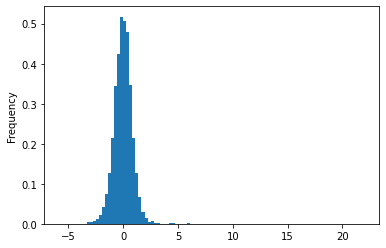

In [23]:
display(round(tmax_per_station["11034_predicted_err"].describe(), 3))
tmax_per_station["11034_predicted_err"].plot.hist(bins=100, density=True);

Daraus können wir bereits mehrere Erkenntnisse gewinnen:

- Der Mittelwert des Fehlers ist 0. Das muss auch so sein, denn das Regressionsmodell wurde aus
  diesen Daten gewonnen und der Mittelwert geht in die Berechnung ein. Wäre er nicht 0, hätten wir
  eine Verzerrung (Bias), also eine systematische Über- bzw. Unterschätzung.
- Die Grafik zeigt eine schöne Normalverteilung. Der Fehler ist also normalverteilt.
- Die Perzentile für 25% und 75% ist ± 0.51°. Das bedeutet, dass 50% der Werte einen Fehler von
  unter 0.51° haben, 50% jedoch einen Fehler von über ± 0.51°.
- Das Maximum ist 22° Differenz. So ein großer Unterschied auf 20km Entfernung ist sehr unwahrscheinlich.
  Es handelt sich also um einen falschen Wert. Wir können daher Regressionsmodelle zur Feststellung
  von Ausreißern (outliers) verwenden.

### Die Normalverteilung des Fehlers

Wir wollen nun die Eigenschaft der Normalverteilung des Fehlers nutzen, um eine Aussage treffen
zu können: Wie groß ist der Fehler in Zahlen, sodass 95% der Vorhersagen innerhalb dieses Fehlers
liegen. 95% bedeutet, dass die unteren 2.5% und die oberen 2.5% nicht berücksichtigt werden. Mit der
Funktion *quantile()* können wir diese Grenzen aus dem Datenbestand direkt bestimmen:

In [24]:
print(round(tmax_per_station["11034_predicted_err"].quantile(q=0.05/2), 2))
print(round(tmax_per_station["11034_predicted_err"].quantile(q=1-0.05/2), 2))

-1.68
1.54


Das Ergebnis ist also: 95% der Werte haben einen Fehler von -1.68 bis 1.54. Doch können wir das
auch ohne vollständiges Durchrechnen des Fehlers ermitteln? Bei großen Datensets müssen wir für
jede Zeile einmal den Fehler ermitteln und dann die Quantile bestimmen. Das ist recht aufwändig.

Wir vorher diskutiert ist der Mittelwert des Fehlers immer 0 und er ist normalverteilt. Für eine
Normalverteilung wird noch die Standardabweichung benötigt, die wir aus dem Fehler gewinnen.
Damit können wir die Fehlerverteilung ansetzen:

In [25]:
from scipy.stats import norm
import math

error_dist = norm(0, tmax_per_station["11034_predicted_err"].std())
print(f"95% der Werte haben einen Fehler von {error_dist.ppf(0.05/2)} bis {error_dist.ppf(1-0.05/2)}°")


95% der Werte haben einen Fehler von -1.7004556858948383 bis 1.7004556858948379°


Da die Normalverteilung eine Näherung an die echten Daten darstellt, ergibt sich eine kleine Abweichung.
Diese kann aber vernachlässigt werden. Da die Normalverteilung perfekt symmetrisch ist, genügt die
Angabe eines Wertes mit einem ± Zeichen:

In [26]:
print(f"95% der Werte haben einen Fehler von ±{-error_dist.ppf(0.05/2)}°")

95% der Werte haben einen Fehler von ±1.7004556858948383°


### Der Korrelationskoeffizient als "Varianzerklärungsanteil"

Der Korrelationskoeffizient gibt an, wie viel % der Varianz durch ein lineares Modell erklärt
werden kann. Wenn wir diesen berechnen, und die Varianz der X Werte wissen, können wir direkt
auf den Fehler schließen:

In [27]:
valid_data = tmax_per_station[11034].notna() & tmax_per_station[11082].notna()
corr_coeff = np.corrcoef(tmax_per_station.loc[valid_data, [11082, 11034]], rowvar=False)[0][1]
std_err = math.sqrt(tmax_per_station[11034].var() * (1-corr_coeff*corr_coeff))

print(f"Der Standardfehler des Regressionsmodelles beträgt {round(std_err, 2)}°")
print(f"Für 95% der Werte liegt der Fehler innerhalb von  ±{round(-norm().ppf(0.05/2)*std_err, 2)}°")
print(f"Für 50% der Werte liegt der Fehler innerhalb von  ±{round(-norm().ppf(0.5/2)*std_err, 2)}°")

Der Standardfehler des Regressionsmodelles beträgt 0.87°
Für 95% der Werte liegt der Fehler innerhalb von  ±1.7°
Für 50% der Werte liegt der Fehler innerhalb von  ±0.59°
